In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from paraspec.base import IR12SpeciationModel

%matplotlib inline

# Run the model in a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

X, Y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

environment = X * 10 + r.rand(*Y.shape)

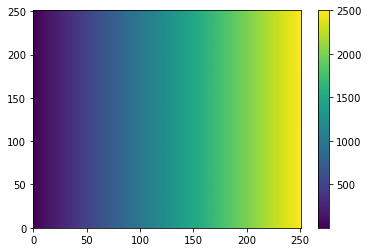

In [3]:
plt.pcolormesh(environment)
plt.colorbar();

# Initial parameters for speciation models

In [4]:
pop_size = 100
num_gen = 1000
plot_at = np.linspace(0,num_gen-1,10).astype(int)
dt = 1e0

## Speciation model without trait-mediated competition

In [5]:
def mode1_run():
    env_fileds = np.stack([environment, environment])
    env_fileds_min = []
    env_fileds_max = []
    for i in range(env_fileds.shape[0]):
        env_fileds_min.append(env_fileds[i,:,:].min().round())
        env_fileds_max.append(env_fileds[i,:,:].max().round())
    
    model1 = IR12SpeciationModel(X, Y, pop_size, nb_radius=50, car_cap=25,
                                 slope_trait_env = [0.95, -0.95],
                                 sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
                                 mut_prob=0.05, random_seed=1234)
    print(model1)
    model1.initialize([[0.5, 0.5], [0.5, 0.5]])
    dfs1 = []
    for step in range(num_gen):
        model1.evaluate_fitness(env_fileds, env_fileds_min, env_fileds_max, dt)
        dfs1.append(model1.to_dataframe())
        model1.update_individuals(dt)
    return pd.concat(dfs1)

In [6]:
%time population1 = mode1_run()
population1

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    slope_trait_env: [0.95, -0.95]
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    nb_radius: 50
    car_cap: 25
    sigma_env_trait: 0.2
    sigma_mov: 5
    sigma_mut: 0.05
    mut_prob: 0.05
    on_extinction: warn

CPU times: user 35.7 s, sys: 788 ms, total: 36.5 s
Wall time: 36.6 s


,step,time,dt,id,parent,x,y,fitness,n_offspring,trait_0,trait_1
0,0,0.0,0.0,0,0,186.818327,143.103259,0.250409,1,0.500000,0.500000
1,0,0.0,0.0,1,1,0.517769,122.754664,0.003888,0,0.500000,0.500000
2,0,0.0,0.0,2,2,202.339080,179.922215,0.117857,0,0.500000,0.500000
3,0,0.0,0.0,3,3,201.702223,115.946603,0.117776,0,0.500000,0.500000
4,0,0.0,0.0,4,4,13.633167,212.778365,0.011735,0,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
244,999,999.0,0.0,226209,225960,237.130543,194.807658,0.869537,1,0.961741,0.173853
245,999,999.0,0.0,226210,225961,239.707215,214.040401,0.917487,1,1.003029,0.113282
246,999,999.0,0.0,226211,225962,243.454949,224.427322,0.886883,1,0.911142,0.142374
247,999,999.0,0.0,226212,225963,221.424119,239.488414,0.659262,1,1.019372,0.038200


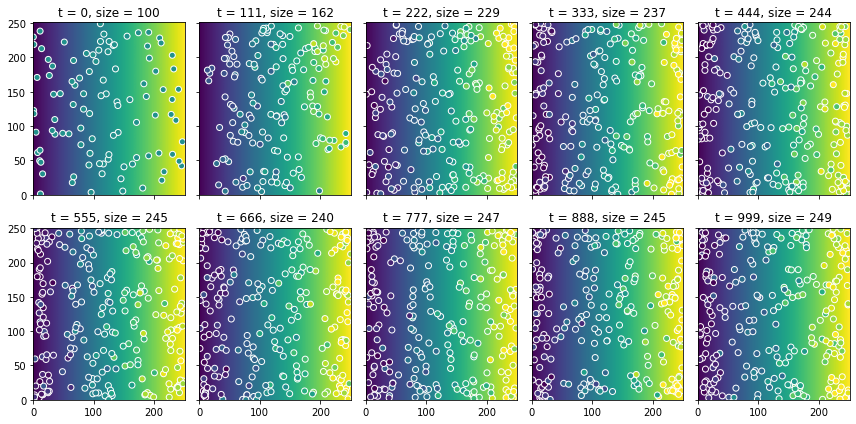

In [7]:
fig1, axes1 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes1.ravel(), plot_at):
    pop = population1.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig1.tight_layout()

Text(0.5, 0, 'Time (generations)')

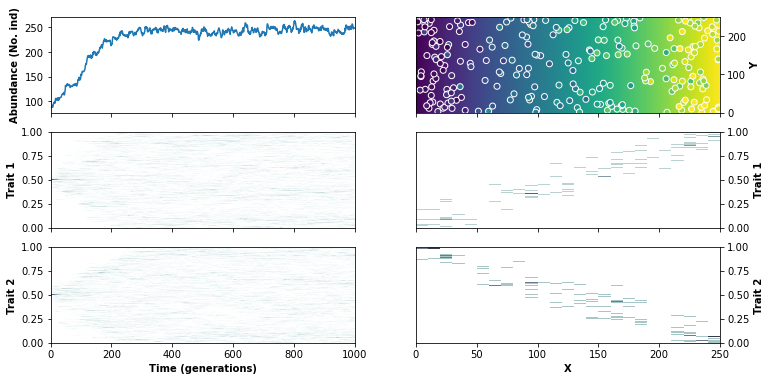

In [8]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
axs2[0,0].plot(population1.groupby('step').size())

axs2[0, 1].pcolormesh(environment)
axs2[0, 1].scatter(population1['x'].loc[population1['step']==max(population1['step'])], 
                   population1['y'].loc[population1['step']==max(population1['step'])], 
                   c=population1['trait_0'].loc[population1['step']==max(population1['step'])],
                   edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs2[1,1].hist2d(x=population1['x'].loc[population1['step']==max(population1['step'])], 
                                 y=population1['trait_0'].loc[population1['step']==max(population1['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[1,0].hist2d(x=population1['step'], y=population1['trait_0'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,1].hist2d(x=population1['x'].loc[population1['step']==max(population1['step'])], 
                                 y=population1['trait_1'].loc[population1['step']==max(population1['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=population1['step'], y=population1['trait_1'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
axs2[0, 1].yaxis.set_label_position("right")
axs2[0, 1].yaxis.tick_right()
axs2[1, 1].yaxis.set_label_position("right")
axs2[1, 1].yaxis.tick_right()
axs2[2, 1].yaxis.set_label_position("right")
axs2[2, 1].yaxis.tick_right()
axs2[0, 1].set_ylabel('Y', weight='bold')
axs2[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1, 1].set_ylabel('Trait 1', weight='bold')
axs2[1, 0].set_ylabel('Trait 1', weight='bold')
axs2[2, 1].set_ylabel('Trait 2', weight='bold')
axs2[2, 0].set_ylabel('Trait 2', weight='bold')
axs2[2, 1].set_xlabel('X', weight='bold')
axs2[2, 0].set_xlabel('Time (generations)', weight='bold')

## Speciation model with trait-mediated competition

In [9]:
from paraspec.base import DD03SpeciationModel

In [10]:
def model2_run():
    env_fileds = np.stack([environment, environment])
    env_fileds_min = []
    env_fileds_max = []
    for i in range(env_fileds.shape[0]):
        env_fileds_min.append(env_fileds[i,:,:].min().round())
        env_fileds_max.append(env_fileds[i,:,:].max().round())

    model2 = DD03SpeciationModel(X, Y, pop_size, birth_rate=1, movement_rate=5, 
                                 slope_trait_env= [0.95, -0.95],
                                 car_cap_max=250, sigma_env_trait=0.2, 
                                 mut_prob=0.05, sigma_mut=0.05, sigma_mov=5, sigma_comp_trait=0.9, 
                                 sigma_comp_dist=0.1, random_seed=1234)
    print(model2)
    model2.initialize([[0.5, 0.5], [0.5, 0.5]])
    dfs2 = []
    for step in range(num_gen):
        model2.evaluate_fitness(env_fileds, env_fileds_min, env_fileds_max, dt)
        dfs2.append(model2.to_dataframe())
        model2.update_individuals(dt)
    return pd.concat(dfs2)

In [11]:
%time population2 = model2_run()
population2

<DD03SpeciationModel (individuals: not initialized)>
Parameters:
    slope_trait_env: [0.95, -0.95]
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    birth_rate: 1
    movement_rate: 5
    car_cap_max: 250
    sigma_env_trait: 0.2
    mut_prob: 0.05
    sigma_mut: 0.05
    sigma_mov: 5
    sigma_comp_trait: 0.9
    sigma_comp_dist: 0.1

CPU times: user 31.6 s, sys: 851 ms, total: 32.5 s
Wall time: 32.6 s


,step,time,dt,id,parent,x,y,events_i,death_i,n_offspring,trait_0,trait_1
0,0,0.0,0.0,0,0,186.818327,143.103259,D,1.248794,0,0.500000,0.500000
1,0,0.0,0.0,1,1,0.517769,122.754664,D,66.647332,0,0.500000,0.500000
2,0,0.0,0.0,2,2,202.339080,179.922215,M,2.817552,1,0.500000,0.500000
3,0,0.0,0.0,3,3,201.702223,115.946603,M,2.344043,1,0.500000,0.500000
4,0,0.0,0.0,4,4,13.633167,212.778365,B,28.791455,2,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
435,999,999.0,1.0,38297,38141,122.805067,214.794072,M,1.999027,1,0.408956,0.490627
436,999,999.0,1.0,38298,38184,158.842247,67.311629,D,3.206958,0,0.824800,0.326447
437,999,999.0,1.0,38299,38218,64.232407,107.105622,B,1.900400,2,0.246816,0.686025
438,999,999.0,1.0,38300,38225,222.407796,99.168482,D,3.905125,0,0.692219,0.334387


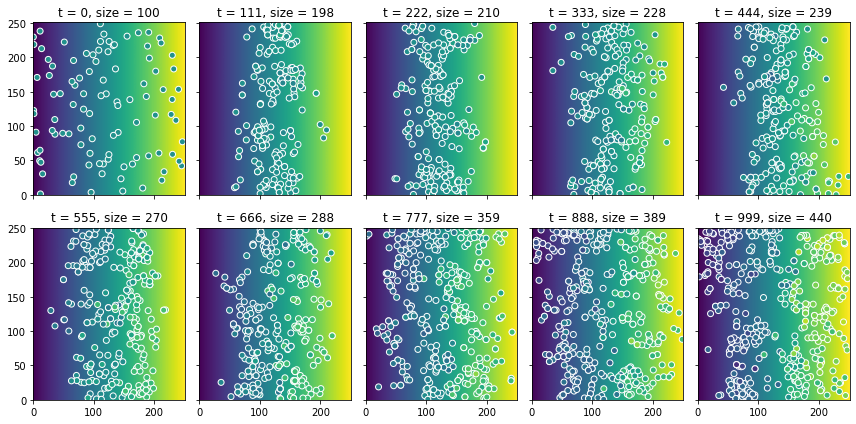

In [12]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes3.ravel(), plot_at):
    pop = population2.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig3.tight_layout()

Text(0.5, 0, 'Time (generations)')

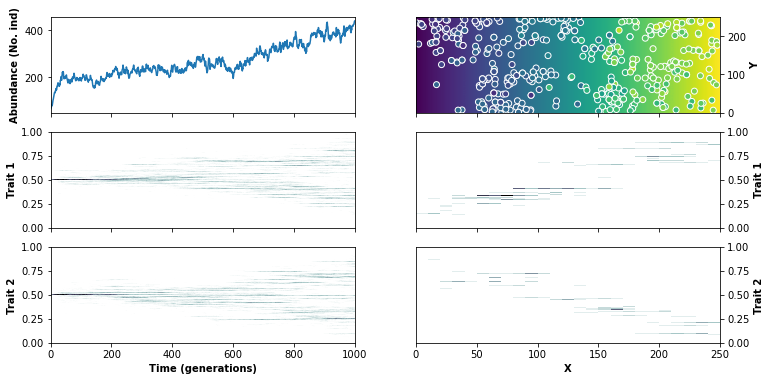

In [13]:
fig4, axs4 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
axs4[0,0].plot(population2.groupby('step').size())
axs4[0, 1].pcolormesh(environment)
axs4[0, 1].scatter(population2['x'].loc[population2['step']==max(population2['step'])], 
                      population2['y'].loc[population2['step']==max(population2['step'])], 
                      c=population2['trait_0'].loc[population2['step']==max(population2['step'])], 
                      edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs4[1,1].hist2d(x=population2['x'].loc[population2['step']==max(population2['step'])], 
                                 y=population2['trait_0'].loc[population2['step']==max(population2['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[1,0].hist2d(x=population2['step'], y=population2['trait_0'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
h,xedge,yedge,_=axs4[2,1].hist2d(x=population2['x'].loc[population2['step']==max(population2['step'])], 
                                 y=population2['trait_1'].loc[population2['step']==max(population2['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[2,0].hist2d(x=population2['step'], y=population2['trait_1'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
axs4[0, 1].yaxis.set_label_position("right")
axs4[0, 1].yaxis.tick_right()
axs4[1, 1].yaxis.set_label_position("right")
axs4[1, 1].yaxis.tick_right()
axs4[2, 1].yaxis.set_label_position("right")
axs4[2, 1].yaxis.tick_right()
axs4[0, 1].set_ylabel('Y', weight='bold')
axs4[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs4[1, 1].set_ylabel('Trait 1', weight='bold')
axs4[1, 0].set_ylabel('Trait 1', weight='bold')
axs4[2, 1].set_ylabel('Trait 2', weight='bold')
axs4[2, 0].set_ylabel('Trait 2', weight='bold')
axs4[2, 1].set_xlabel('X', weight='bold')
axs4[2, 0].set_xlabel('Time (generations)', weight='bold')

In [14]:
#%timeit mode1_run()

In [15]:
#%timeit model2_run()